# 2.1
a) Function constructing VX and VY

In [3]:
import numpy as np
def xy(x0, y0, L1, L2, noelms1, noelms2):
    lx = L1 / noelms1
    ly = L2 / noelms2

    VX = np.repeat([x0 + i * lx for i in range(noelms1 + 1)], noelms2 + 1)
    VY = [y0 + j * ly for j in range(noelms2,-1,-1)] * (noelms1 + 1)

    return np.array(VX), np.array(VY)

In [4]:

(x0, y0) = (-2.5,-4.8)
L1 = 7.6
L2 = 5.9
noelms1 = 4
noelms2 = 3


VX,VY = xy(x0,y0,L1,L2,noelms1,noelms2)

print(VX)
print(VY)

print(len(VX))
print(len(VY))


[-2.5 -2.5 -2.5 -2.5 -0.6 -0.6 -0.6 -0.6  1.3  1.3  1.3  1.3  3.2  3.2
  3.2  3.2  5.1  5.1  5.1  5.1]
[ 1.1        -0.86666667 -2.83333333 -4.8         1.1        -0.86666667
 -2.83333333 -4.8         1.1        -0.86666667 -2.83333333 -4.8
  1.1        -0.86666667 -2.83333333 -4.8         1.1        -0.86666667
 -2.83333333 -4.8       ]
20
20


b) Function constructing EToV

In [5]:
def conelmtab(noelms1,noelms2):
    EToV = []
    for j in range(noelms1):
        for i in range(noelms2):
            EToV.append([i+noelms2+1+(noelms2+1)*j,i+(noelms2+1)*j, i+noelms2+2+(noelms2+1)*j])
            EToV.append([i+1+(noelms2+1)*j,i+noelms2+2+(noelms2+1)*j,i+(noelms2+1)*j])

    return np.array(EToV)

EToV = conelmtab(4,3)

EToV

array([[ 4,  0,  5],
       [ 1,  5,  0],
       [ 5,  1,  6],
       [ 2,  6,  1],
       [ 6,  2,  7],
       [ 3,  7,  2],
       [ 8,  4,  9],
       [ 5,  9,  4],
       [ 9,  5, 10],
       [ 6, 10,  5],
       [10,  6, 11],
       [ 7, 11,  6],
       [12,  8, 13],
       [ 9, 13,  8],
       [13,  9, 14],
       [10, 14,  9],
       [14, 10, 15],
       [11, 15, 10],
       [16, 12, 17],
       [13, 17, 12],
       [17, 13, 18],
       [14, 18, 13],
       [18, 14, 19],
       [15, 19, 14]])

# 2.2

a) basis function.

In [6]:
from matplotlib import pyplot as plt

def basfun(n,VX,VY,EToV):
    idx1 = EToV[n,0]
    idx2 = EToV[n,1]    
    idx3 = EToV[n,2]

    x1 = VX[idx1]
    x2 = VX[idx2]
    x3 = VX[idx3]

    y1 = VY[idx1]
    y2 = VY[idx2]
    y3 = VY[idx3]

    delta = 1/2*(x2*y3 - x3*y2 - x1*y3 + x3*y1 + x1*y2 - x2*y1)

    abc = np.zeros((3,3))

    abc[0,0] = x2*y3 - x3*y2
    abc[0,1] = y2 - y3
    abc[0,2] = x3 - x2

    abc[1,0] = x3*y1 - x1*y3
    abc[1,1] = y3 - y1
    abc[1,2] = x1 - x3

    abc[2,0] = x1*y2 - x2*y1
    abc[2,1] = y1 - y2
    abc[2,2] = x2 - x1


    return delta, abc


    # plt.plot(VX,VY,'o')
    # plt.plot([x1,x2,x3],[y1,y2,y3],'o')


(x0, y0) = (-2.5,-4.8)
L1 = 7.6
L2 = 5.9
noelms1 = 4
noelms2 = 3

VX,VY = xy(x0,y0,L1,L2,noelms1,noelms2)
EToV = conelmtab(noelms1,noelms2)

delta, abc = basfun(3,VX,VY,EToV)

print(delta)
print(abc)

1.8683333333333327
[[-6.56333333 -1.96666667 -1.9       ]
 [ 4.91666667  1.96666667  0.        ]
 [ 5.38333333  0.          1.9       ]]


b) normal vector component function

In [7]:
def outernormal(n,k,VX,VY,EToV):
    idx1 = EToV[n,(k % 3)]
    idx2 = EToV[n,((k + 1) % 3)]

    dx = VX[idx2] - VX[idx1]
    dy = VY[idx2] - VY[idx1]

    n = np.array([-dy,dx])/np.sqrt(dx*dx+dy*dy)

    return n

outernormal(8,1,VX,VY,EToV)

array([0.71919139, 0.69481202])

# 2.3
a) assembly process

In [26]:
import scipy.sparse as sp

def assembly(VX, VY, EToV, lam1,lam2, qt):
    N = len(EToV[:,1])
    M = len(VX)

    nnzmax = 9*N
    ii = np.zeros(nnzmax, dtype=int)
    jj = np.zeros(nnzmax, dtype=int)
    ss = np.zeros(nnzmax)
    b = np.zeros(M)
    count = 0
    
    for n in range(N):
        delta, abc = basfun(n,VX,VY,EToV)

        i = EToV[n,0]
        j = EToV[n,1]    
        k = EToV[n,2]
            
        triplet = [i,j,k]

        x1 = VX[i]
        x2 = VX[j]
        x3 = VX[k]

        y1 = VY[i]
        y2 = VY[j]
        y3 = VY[k]
        
        for r in range(3):
        
            qtilde = 1/3*(qt(x1,y1)+qt(x2,y2)+qt(x3,y3))
            b[triplet[r]] += (np.abs(delta)/3)*qtilde

            for s in range(3):
                
                k_rs = 1/(4*np.abs(delta))*(lam1*abc[r,1]*abc[s,1]+lam2*abc[r,2]*abc[s,2])
                
                ii[count] = triplet[r]
                jj[count] = triplet[s]
                ss[count] = k_rs
                count += 1


    A = sp.csr_matrix((ss[:count], (ii[:count], jj[:count])), shape=(M, M))
    return A,b

In [27]:
(x0, y0) = (0,0) 
L1 = 1
L2 = 1
noelms1 = 4
noelms2 = 3
q = lambda x,y: 0
lam1 = 1
lam2 = 1

# (x0, y0) = (-2.5, -4.8) 
# L1 = 7.6
# L2 = 5.9
# noelms1 = 4
# noelms2 = 3
# q = lambda x,y: -6*x+2*y-2
# lam1 = 1
# lam2 = 1

VX,VY = xy(x0,y0,L1,L2,noelms1,noelms2)
EToV = conelmtab(noelms1,noelms2)

A,b = assembly(VX, VY, EToV, lam1,lam2, q)


In [10]:
np.diag(A.todense(), k=-4)

array([-0.66666667, -1.33333333, -1.33333333, -0.66666667, -0.66666667,
       -1.33333333, -1.33333333, -0.66666667, -0.66666667, -1.33333333,
       -1.33333333, -0.66666667, -0.66666667, -1.33333333, -1.33333333,
       -0.66666667])

# 2.4

In [28]:
def dirbc(bnodes, f, A, b):
    M = len(b)
    for n,i in enumerate(bnodes):
        A[i,i] = 1
        b[i] = f[n]

        for j in range(M):
            if j != i:
                A[i,j] = 0
                if j not in bnodes:
                    b[j] -= A[j,i]*f[n]
                    A[j,i] = 0
    
    return A,b

In [29]:
def dirbc(bnodes, f, A, b):
    M = len(b)
    for n,i in enumerate(bnodes):
        A[i,i] = 1
        b[i] = f[n]

        for j in range(M):
            if j != i and A[i,j] != 0:
                A[i,j] = 0
                if j not in bnodes:
                    b[j] -= A[j,i]*f[n]
                    A[j,i] = 0
    
    return A,b

In [30]:
def find_bnodes(noelms1,noelms2):
    bnodes = np.arange(noelms2+1)
    for j in range(1,noelms1):
        bnodes = np.append(bnodes, j*(noelms2+1))
        bnodes = np.append(bnodes, j*(noelms2+1) + noelms2)

    bnodes = np.append(bnodes, np.arange((noelms2+1)*noelms1, (noelms2+1)*(noelms1+1)))

    return bnodes

In [34]:
# (x0, y0) = (0,0) 
# L1 = 1
# L2 = 1
# noelms1 = 4
# noelms2 = 3
# q = lambda x,y: 0
# lam1 = 1
# lam2 = 1
# bnodes = find_bnodes(noelms1,noelms2)
# f = np.ones((noelms1+1)*(noelms2+1))


(x0, y0) = (-2.5, -4.8) 
L1 = 7.6
L2 = 5.9
noelms1 = 4
noelms2 = 3
q = lambda x,y: -6*x+2*y-2
lam1 = 1
lam2 = 1
bnodes = find_bnodes(noelms1,noelms2)


VX,VY = xy(x0,y0,L1,L2,noelms1,noelms2)
VX = np.array(VX)
VY = np.array(VY)

f = lambda x,y: x**3 - x**2*y + y**2 - 1

EToV = conelmtab(noelms1,noelms2)
A,b = assembly(VX, VY, EToV, lam1,lam2, q)

A, b = dirbc(bnodes, f(VX[bnodes],VY[bnodes]), A, b)

[-22.29       -10.45722222   9.11111111  36.415       -0.402
  23.552        0.548       32.349       21.714      103.96
 104.25       154.94411111 213.37377778 279.539     ]
[-22.29       -10.45722222   9.11111111  36.415       -0.402
  23.552        0.548       32.349       21.714      103.96
 104.25       154.94411111 213.37377778 279.539     ]


# 2.5

In [38]:
def BVP2D(x0,y0,L1,L2,noelms1,noelms2,q,lam1,lam2,f):
    VX,VY = xy(x0,y0,L1,L2,noelms1,noelms2)
    EToV = conelmtab(noelms1,noelms2)
    bnodes = find_bnodes(noelms1,noelms2)

    A,b = assembly(VX, VY, EToV, lam1,lam2, q)
    farr = f(VX[bnodes], VY[bnodes])
    A, b = dirbc(bnodes, farr, A, b)

    u = sp.linalg.spsolve(A,b)

    return u, VX, VY

*Test case 1*

For given $U(x,y) = x^3-x^2y+y^2-1$ we find
\begin{align}
u_{xx} = 6x-2y \\
u_{yy} = 2
\end{align}
Which yields for $\tilde{q}(x,y) = -u_{xx} - u_{yy} = -6x + 2y -2$

For $f(x,y)$ we obtain $f(x,y) = x^3-x^2y+y^2-1$ for $(x,y) \in \Gamma $

*Test case 2*

For given $U(x,y) = x^2y^2$ we find
\begin{align}
u_{xx} = 2y^2 \\
u_{yy} = 2x^2
\end{align}
Which yields for $\tilde{q}(x,y) = -u_{xx} - u_{yy} = -2(y^2 + x^2)$

For $f(x,y)$ we obtain $f(x,y) = x^2y^2$ for $(x,y) \in \Gamma $

In [85]:
#Test case 1
(x0, y0) = (-2.5, -4.8) 
L1 = 7.6
L2 = 5.9
noelms1 = 10
noelms2 = 10
lam1 = 1
lam2 = 1
q = lambda x,y: -6*x+2*y-2
f = lambda x,y: x**3 - x**2*y + y**2 - 1

u, VX, VY = BVP2D(x0,y0,L1,L2,noelms1,noelms2,q,lam1,lam2,f)

u_exact = f(VX,VY)

E = np.linalg.norm(u-u_exact, np.inf)

print(E)


1.2789769243681803e-13


In [ ]:
H = np.logspace(0,-1,10)
error = np.zeros(len(H))

(x0, y0) = (-2.5, -4.8) 
L1 = 7.6
L2 = 5.9
# noelms1 = 4
# noelms2 = 3
lam1 = 1
lam2 = 1
q = lambda x,y: -6*x+2*y-2
f = lambda x,y: x**3 - x**2*y + y**2 - 1

for i,h in enumerate(H):
    noelms1 = int(L1/h)
    noelms2 = int(L2/h)

    u, VX, VY = BVP2D(x0,y0,L1,L2,noelms1,noelms2,q,lam1,lam2,f)
    u_exact = f(VX,VY)
    error[i] = np.linalg.norm(u-u_exact, np.inf)

In [ ]:
from matplotlib import pyplot as plt
a,b = np.polyfit(np.log(H), np.log(error), 1)
plt.loglog(H,error,'r--')

In [87]:
(x0, y0) = (-2.5, -4.8) 
L1 = 7.6
L2 = 5.9
noelms1 = 4
noelms2 = 3
lam1 = 1
lam2 = 1
q = lambda x,y: -2*(x**2+y**2)
f = lambda x,y: x**2*y**2

u, VX, VY = BVP2D(x0,y0,L1,L2,noelms1,noelms2,q,lam1,lam2,f)

u_exact = f(VX,VY)

E = np.linalg.norm(u-u_exact, np.inf)

print(E)


17.923618905618945


In [133]:
P = list(range(2,7))
error = np.zeros(len(P))

for i,p in enumerate(P):
    noelms1 = 2**p
    noelms2 = 2**p

    u, VX, VY = BVP2D(x0,y0,L1,L2,noelms1,noelms2,q,lam1,lam2,f)
    u_exact = f(VX,VY)
    error[i] = np.linalg.norm(u-u_exact, np.inf)


In [134]:
DOF = [(2**p+1)**2 for p in P]

In [140]:
-2*np.log(2)*np.array(P)

array([-2.77258872, -4.15888308, -5.54517744, -6.93147181, -8.31776617])

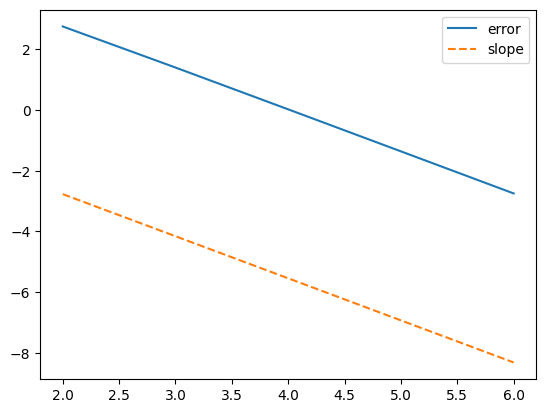

In [151]:
#plt.loglog(DOF,error,'r--')
#plt.semilogy(P,error)
plt.plot(P,np.log(error), label='error')
plt.plot(P,-2*np.log(2)*np.array(P),'--', label='slope')
plt.legend()
plt.show()

# 2.6

In [ ]:
def find_bedges(bnodes, noelms1):
    for i in range(noelms1-1):
        bedges[i] = (bnodes[i], bnodes[i+1])
    
    for i in range(noelms1-1,len(bnodes)-noelms1-1):



    return bnodes